# Example using the `DANN` class defined in this module

## Data

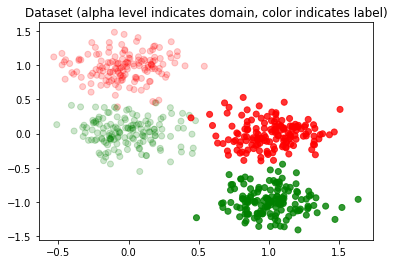

In [1]:
%matplotlib inline

from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)

X_source, y_source = make_blobs(300, centers=[[0, 0], [0, 1]], cluster_std=0.2)
X_target, y_target = make_blobs(300, centers=[[1, -1], [1, 0]], cluster_std=0.2)

plt.scatter(X_source[:,0], X_source[:,1], c=[["g", "r"][k] for k in y_source], alpha=0.2)
plt.scatter(X_target[:,0], X_target[:,1], c=[["g", "r"][k] for k in y_target],  alpha=0.8)
plt.title("Dataset (alpha level indicates domain, color indicates label)");

## Model parts

We are now ready to build our model to be trained with DANN strategy.
Let us first build its parts.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

latent_space_dim = 16

feature_extractor = Sequential([
    Dense(units=latent_space_dim, activation="relu", input_dim=2),
    Dense(units=latent_space_dim, activation="relu")
])
classifier = Sequential([
    Dense(units=latent_space_dim, activation="relu", input_dim=latent_space_dim),
    Dense(units=1, activation="sigmoid")
])
domain_classifier = Sequential([
    Dense(units=latent_space_dim, activation="relu", input_dim=latent_space_dim),
    Dense(units=1, activation="sigmoid")
])


In [3]:
print(feature_extractor.inputs, classifier.outputs, domain_classifier.outputs)

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_input')>] [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_3')>] [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_5')>]


Now we can define our DANN model on top of those parts:

In [4]:
from kerasDANN.model import DANN

model = DANN(
    feature_extractor=feature_extractor,
    label_predictor=classifier,
    domain_classifier=domain_classifier,
    loss_lambda=2.
)




In [5]:
from sklearn.metrics import accuracy_score

model.label_model_.fit(X_source, y_source, epochs=10)
acc_source = accuracy_score(y_source, model(X_source) > 0.5)
print(f"10 epochs done, source accuracy={acc_source}, no DA yet")

Epoch 1/10
10/10 [==============================] - 0s 1ms/step - loss: 0.6771 - accuracy: 0.4914
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 0.6615 - accuracy: 0.5677
Epoch 3/10
10/10 [==============================] - 0s 2ms/step - loss: 0.6451 - accuracy: 0.6725
Epoch 4/10
10/10 [==============================] - 0s 1ms/step - loss: 0.6234 - accuracy: 0.8303
Epoch 5/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5942 - accuracy: 0.9223
Epoch 6/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5706 - accuracy: 0.9449
Epoch 7/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5279 - accuracy: 0.9542
Epoch 8/10
10/10 [==============================] - 0s 2ms/step - loss: 0.4869 - accuracy: 0.9363
Epoch 9/10
10/10 [==============================] - 0s 2ms/step - loss: 0.4347 - accuracy: 0.9748
Epoch 10/10
10/10 [==============================] - 0s 3ms/step - loss: 0.3806 - accuracy: 0.9596
10 epochs done, sou

In [6]:
from sklearn.metrics import accuracy_score

for n_repeats in range(10):
    model.fit((X_source, X_target), y_source, epochs=10)
    acc_source = accuracy_score(y_source, model(X_source) > 0.5)
    acc_target = accuracy_score(y_target, model(X_target) > 0.5)
    print(f"10 epochs done, source accuracy={acc_source}, target accuracy={acc_target}")
    


10 epochs done, source accuracy=0.9866666666666667, target accuracy=0.5
10 epochs done, source accuracy=0.99, target accuracy=0.5033333333333333
10 epochs done, source accuracy=0.99, target accuracy=0.5166666666666667
10 epochs done, source accuracy=0.99, target accuracy=0.5733333333333334
10 epochs done, source accuracy=0.99, target accuracy=0.6233333333333333
10 epochs done, source accuracy=0.99, target accuracy=0.6733333333333333
10 epochs done, source accuracy=0.9833333333333333, target accuracy=0.6766666666666666
10 epochs done, source accuracy=0.9833333333333333, target accuracy=0.9266666666666666
10 epochs done, source accuracy=0.9766666666666667, target accuracy=0.7233333333333334
10 epochs done, source accuracy=0.99, target accuracy=0.6766666666666666
